In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
print("--- Transfer Learning with VGG16 for CIFAR-10 Classification ---")

--- Transfer Learning with VGG16 for CIFAR-10 Classification ---


In [21]:
# --- Step 1: Load and Prepare the CIFAR-10 Dataset ---

# Load the CIFAR-10 dataset. The images are 32x32 color images.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [22]:
# Normalize pixel values to the range [0, 1] for better training.
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [5]:
# VGG16 was trained on 224x224 images. We need to resize our 32x32 images to a compatible size.
# We'll use a simple upsampling to resize to 48x48, as this is a multiple of 16 (the
# pooling factor of VGG16). A larger size like 224x224 would take much longer to train.
# from tensorflow.keras.layers import UpSampling2D
# upsample_layer = UpSampling2D(size=(2, 2))
# train_images = upsample_layer(train_images)
# test_images = upsample_layer(test_images)

In [23]:
# Convert labels to one-hot encoding for the final dense layer.
num_classes = 10
train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)
print(f"  Training images shape after resizing: {train_images.shape}")
print(f"  Test images shape after resizing: {test_images.shape}")

  Training images shape after resizing: (50000, 32, 32, 3)
  Test images shape after resizing: (10000, 32, 32, 3)


In [34]:
# Define the class names for CIFAR-10.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [25]:
# --- Step 2: Load the Pre-trained VGG16 Model ---

# Load the VGG16 model with pre-trained weights from ImageNet.
# `weights='imagenet'`: Uses the weights trained on the ImageNet dataset.
# `include_top=False`: Excludes the final dense classification layers, as we need to add our own.
# `input_shape`: The shape of our input images (48x48 pixels with 3 color channels).
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [26]:
# Freeze the VGG16 base layers. This is the core of transfer learning.
# We do this to prevent the pre-trained weights from being modified during training.
for layer in vgg16_base.layers:
    layer.trainable = False

In [27]:
# --- Step 3: Design the New Classifier Head ---

# Create a new Sequential model.
model = Sequential()
# Add the frozen VGG16 base as the first layer.
model.add(vgg16_base)

# Flatten the output of VGG16's feature maps into a 1D vector.
model.add(Flatten())

# Add a dense layer with Dropout for regularization.
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Add the final dense output layer with 10 neurons (for 10 classes).
# 'softmax' activation converts the outputs to probabilities.
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
# We use the Adam optimizer and the appropriate loss function for multi-class classification.
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# --- Step 5: Train the Model ---

epochs = 5
history = model.fit(train_images, train_labels_one_hot,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(test_images, test_labels_one_hot),
                    verbose=1)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.4065 - loss: 1.6811 - val_accuracy: 0.5370 - val_loss: 1.3276
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 764s 2s/step - accuracy: 0.5359 - loss: 1.3320 - val_accuracy: 0.5657 - val_loss: 1.2397
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - accuracy: 0.5576 - loss: 1.2671 - val_accuracy: 0.5729 - val_loss: 1.2137
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.5709 - loss: 1.2238 - val_accuracy: 0.5836 - val_loss: 1.1846
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - accuracy: 0.5826 - loss: 1.1968 - val_accuracy: 0.5889 - val_loss: 1.1675


In [31]:
# --- Step 6: Record and Visualize Results ---

# Get the final training accuracy from the history object.
final_training_accuracy = history.history['accuracy'][-1]
final_test_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_training_accuracy:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Final Training Accuracy: 0.5866
Final Test Accuracy: 0.5889


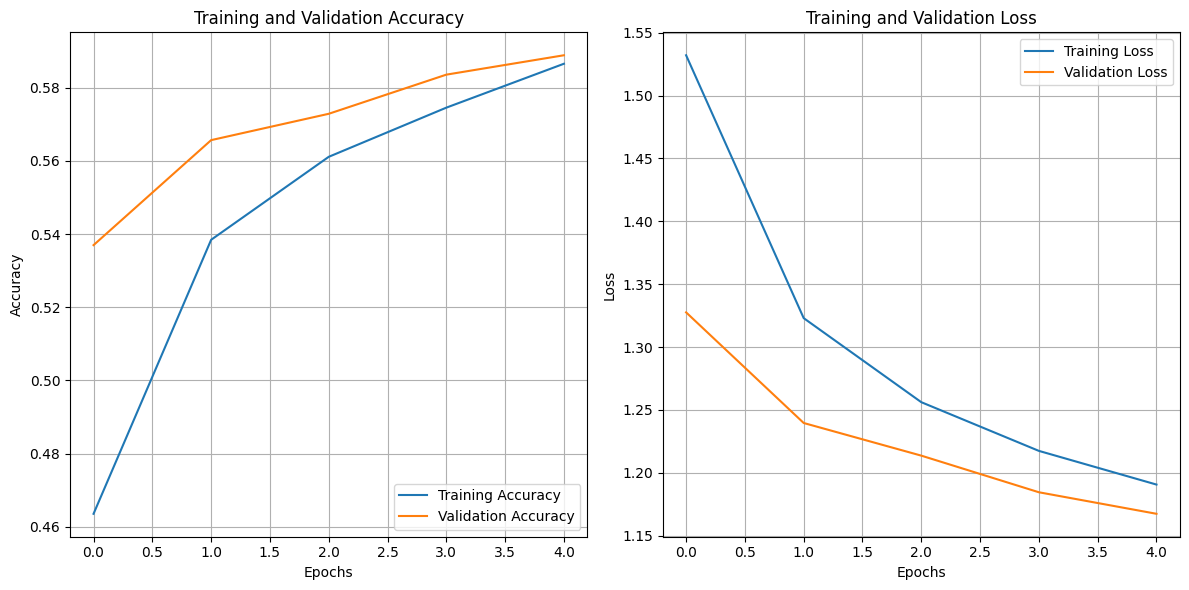

In [32]:
# Plotting the training and validation accuracy and loss over time.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
  Model predicted: 'ship'
  Actual label was: 'ship'
  Prediction probabilities: [0.15 0.01 0.   0.   0.01 0.   0.   0.   0.82 0.01]
------------------------------------------------------------


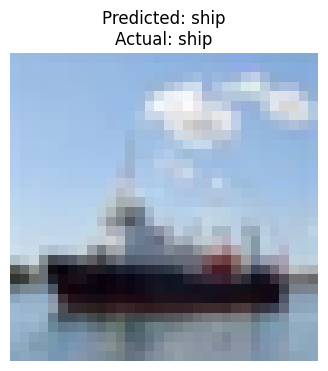

In [41]:
# --- Step 7: Make a Prediction on a Sample Image ---

# Select a random image from the test set.
sample_index = np.random.randint(0, len(test_images))
sample_image = test_images[sample_index]
true_label_index = test_labels[sample_index][0]

# The model expects a batch of images, so we add a batch dimension.
# A single image has a shape of (32, 32, 3). We reshape it to (1, 32, 32, 3).
sample_image_batch = np.expand_dims(sample_image, axis=0)

# Get the model's prediction. The output will be a list of probabilities.
prediction_probabilities = model.predict(sample_image_batch)
predicted_label_index = np.argmax(prediction_probabilities)
predicted_label = class_names[predicted_label_index]
true_label = class_names[true_label_index]

print(f"  Model predicted: '{predicted_label}'")
print(f"  Actual label was: '{true_label}'")
print(f"  Prediction probabilities: {np.round(prediction_probabilities.flatten(), 2)}")
print("-" * 60)

# Display the image with the prediction.
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title(f"Predicted: {predicted_label}\nActual: {true_label}")
plt.axis('off')
plt.show()